# PROYECTO SEGMENTACIÓN DE IMAGENES
 Integrantes:
 - Jaime Alberto Rodriguez - COD
 - Yezid Alejandro Garcia - COD 


In [134]:
import cv2
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import skfuzzy as fuzz

from sklearn.pipeline import Pipeline
from sklearn.cluster import MeanShift, estimate_bandwidth

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.base import BaseEstimator, ClusterMixin, TransformerMixin

In [135]:
class FuzzyCMeans(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusters=3, m=2.0, max_iter=150, error=1e-5, random_state=None):
        self.n_clusters = n_clusters
        self.m = m
        self.max_iter = max_iter
        self.error = error
        self.random_state = random_state

    def fit(self, X, y=None):
        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
            X.T, self.n_clusters, self.m, error=self.error, maxiter=self.max_iter, 
            init=None, seed=self.random_state
        )
        self.cntr_ = cntr
        self.u_ = u
        self.labels_ = np.argmax(u, axis=0)
        return self

    def predict(self, X):
        u, _, _, _, _, _ = fuzz.cluster.cmeans_predict(
            X.T, self.cntr_, self.m, error=self.error, maxiter=self.max_iter
        )
        return np.argmax(u, axis=0)

In [136]:
class ImageUtilities(BaseEstimator, TransformerMixin):
    def __init__(self, scale_percent=50):
        self.scale_percent = scale_percent
        print("Scalating images to {}% of original size".format(scale_percent))

    def fit(self, X, y=None):        
        return self
     
    def transform(self, X):        
        images = []
        for imageName in X:
            try:
                full_image = self.loadImage(imageName)
                resized_image = self.resizeImage(full_image)
                images.append(resized_image)
            except Exception as e:
                print(f"Error loading image {imageName}: {e}")
                continue
        print("Loaded {} images".format(len(images)))        
        return images

    def loadImage(self, imageName):
        # Images are in the same directory as the notebook
        try:
            img = cv2.imread(imageName)
            if img is None:
                raise ValueError(f"Could not load image: {imageName}")
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            return img_rgb
        except Exception as e:
            print(f"Error in loadImage for {imageName}: {e}")
            raise

    def resizeImage(self, img):
        # Escalar la imagen al SP% de su tamaño original    
        width = int(img.shape[1] * self.scale_percent / 100)
        height = int(img.shape[0] * self.scale_percent / 100)
        dim = (width, height)
        img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)        
        return img
    
    def showImage(self, img):
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        print(img.shape)

In [137]:
class ImageSegmentationBenchmark(BaseEstimator, TransformerMixin):
    def __init__(self, k_min, k_max, segmentationMethods, random_state=0):
        self.k_min = k_min
        self.k_max = k_max
        self.random_state = random_state
        self.segmentationMethods = segmentationMethods

    def fit(self, X=None, y=None):
        return self
    
    def transform(self, X):        
        benchmark = []
        for idx, image in enumerate(X):   
            try:
                scaler = StandardScaler()
                original_image = image.copy()
                image_data = scaler.fit_transform(image.reshape((-1, 3)).astype(float)) 
                scores = []
                
                for method in self.segmentationMethods:    
                    for i in range(self.k_min, self.k_max+1):
                        print("Segmenting image {} with {} and k={}".format(idx + 1, method, i))                    
                        try:
                            if method == 'kmeans':
                                model = KMeans(n_clusters=i, random_state=self.random_state, max_iter=300, n_init=10)
                            elif method == 'kmedoids':
                                model = KMedoids(n_clusters=i, random_state=self.random_state, init='k-medoids++', max_iter=300)
                            elif method == 'fuzzy':
                                model = FuzzyCMeans(n_clusters=i, random_state=self.random_state)
                            else:
                                raise ValueError("Método no soportado: {}".format(method))
                            
                            model.fit(image_data)
                            
                            # Check if clustering is valid
                            if len(np.unique(model.labels_)) > 1:
                                score = silhouette_score(image_data, model.labels_)
                                scores.append((method, i, round(score, 3)))
                            else:
                                print(f"Warning: Only one cluster found for {method} k={i}")
                                scores.append((method, i, -1))  # Invalid score
                                
                        except Exception as e:
                            print(f"Error with {method} k={i}: {e}")
                            scores.append((method, i, -1))  # Error score
                            
                benchmark.append((original_image, scores))
                
            except Exception as e:
                print(f"Error processing image {idx}: {e}")
                continue
                
        return benchmark

In [138]:
class ImageSegmentationBenchmarkResult(BaseEstimator, TransformerMixin):
    def fit(self, X=None, y=None):
        return self
    
    def transform(self, X):
        for (image, scores) in X:
            df = pd.DataFrame(scores, columns=['Method', 'K', 'Silhouette Score'])
            # Crear figura con 3 columnas
            fig, axes = plt.subplots(1, 3, figsize=(18, 5))
            
            # Mostrar imagen
            axes[0].imshow(image)
            axes[0].axis('off')
            axes[0].set_title('Imagen')
            
            # Graficar silhouette score por método
            for method in df['Method'].unique():
                subset = df[df['Method'] == method]
                axes[1].plot(subset['K'], subset['Silhouette Score'], marker='o', label=method)
            axes[1].set_xlabel('K')
            axes[1].set_ylabel('Silhouette Score')
            axes[1].set_title('Silhouette Score por Método')
            axes[1].legend()
            axes[1].grid(True)
            
            # Tabla con el valor máximo de cada método
            max_rows = []
            for method in df['Method'].unique():
                subset = df[df['Method'] == method]
                idx_max = subset['Silhouette Score'].idxmax()
                row = subset.loc[idx_max, ['Method', 'K', 'Silhouette Score']]
                max_rows.append(row)
            max_scores = pd.DataFrame(max_rows)


            axes[2].axis('off')
            table = axes[2].table(cellText=max_scores.values,
                                  colLabels=max_scores.columns,
                                  loc='center')
            table.auto_set_font_size(False)
            table.set_fontsize(12)
            
            axes[2].set_title('Máximo Silhouette Score')
            
            plt.tight_layout()
            plt.show()
        return X
        

Scalating images to 35% of original size
Loaded 1 images
Segmenting image 1 with kmeans and k=4
Segmenting image 1 with kmeans and k=5
Segmenting image 1 with kmeans and k=6
Segmenting image 1 with kmeans and k=7
Segmenting image 1 with kmedoids and k=4
Segmenting image 1 with kmedoids and k=5
Segmenting image 1 with kmedoids and k=6
Segmenting image 1 with kmedoids and k=7
Segmenting image 1 with fuzzy and k=4
Segmenting image 1 with fuzzy and k=5
Segmenting image 1 with fuzzy and k=6
Segmenting image 1 with fuzzy and k=7


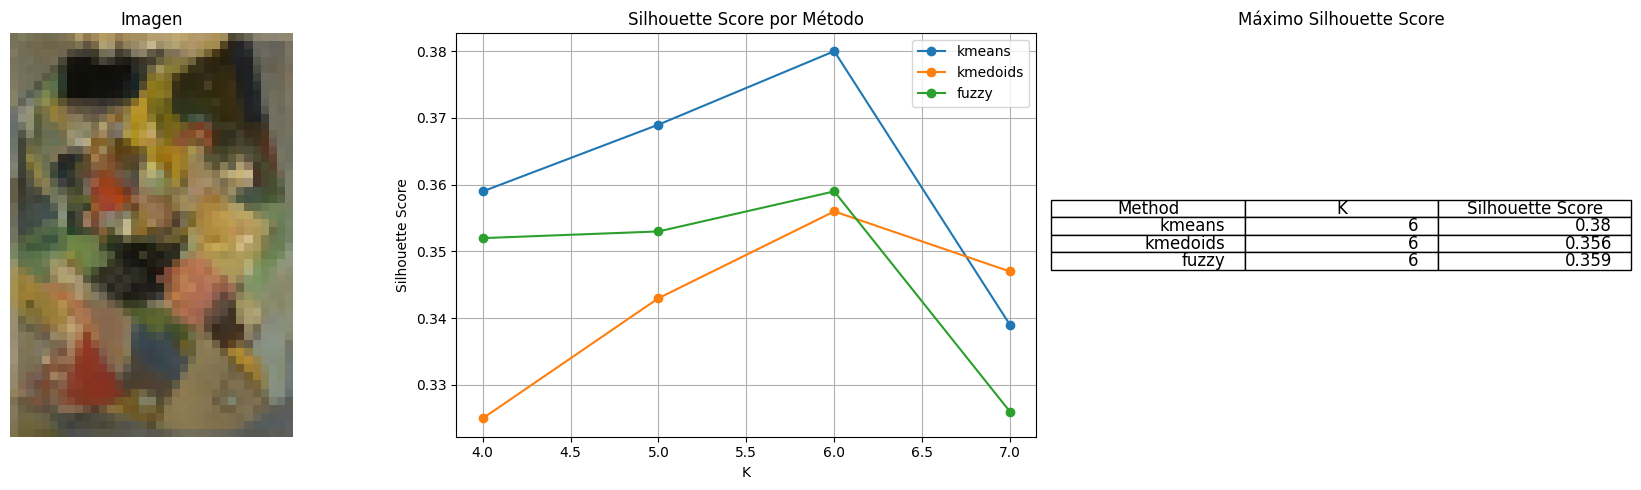

In [139]:
"""
imageNames = ['action_painting_franz-kline.jpg',
               'high-renaissance- andrea-mantegna.jpg',
               'juan-gris_guitar-and-pipe-1913.jpg',
               'minimalism-agnes-martin.jpg',
               'new-realism-edward-hopper.jpg'
               ]

imageNames = ['action_painting_franz-kline.jpg',
               'high-renaissance- andrea-mantegna.jpg'
               ]

imageNames = ['albert-gleizes_acrobats-1916.jpg',
              'albert-gleizes_portrait-of-igor-stravinsky-1914.jpg',
              'antonio-palolo_untitled-1992.jpg',
              'wu-guanzhong_houses-of-the-south-2007.jpg',
              'basil-beattie_cause-and-effect-v-1973.jpg',
              'jack-tworkov_june-21-1964.jpg'
               ]
"""
imageNames = ['albert-gleizes_acrobats-1916.jpg']

#imageNames = ['jpgIcon256.png', 'musicIcon256.png', 'games256.png']
methods = ['kmeans', 'kmedoids', 'fuzzy']
#methods = ['kmeans', 'fuzzy']
#methods = ['kmedoids']

pipe = Pipeline(steps=[
    ("image_load", ImageUtilities(scale_percent=35)),
    ("image_segment_benchmark", ImageSegmentationBenchmark(k_min=4, k_max=7, segmentationMethods=methods, random_state=0)),
    ('image_segment_result', ImageSegmentationBenchmarkResult())
    ])

images = pipe.fit_transform(imageNames)

In [140]:
class ColorPalette(BaseEstimator, TransformerMixin):
    def __init__(self, method='kmeans', k=4, sort_by_frequency=True, figsize=(12, 4)):
        self.method = method
        self.k = k
        self.sort_by_frequency = sort_by_frequency
        self.figsize = figsize

    def fit(self, X=None, y=None):
        return self
    
    def transform(self, X):
        palette_results = []
        
        for img_idx, image in enumerate(X):
            palette_info = self._generate_single_palette(image, img_idx + 1)
            palette_results.append({
                'image': image,
                'palette': palette_info,
                'method_used': self.method,
                'k_used': self.k
            })
        
        return palette_results
    
    def _generate_single_palette(self, image, img_num):
        scaler = StandardScaler()
        image_data = scaler.fit_transform(image.reshape((-1, 3)).astype(float))
        
        # clustering
        if self.method == 'kmeans':
            model = KMeans(n_clusters=self.k, random_state=0, max_iter=300, n_init=10)
        elif self.method == 'kmedoids':
            model = KMedoids(n_clusters=self.k, random_state=0, init='k-medoids++', max_iter=300)
        elif self.method == 'fuzzy':
            model = FuzzyCMeans(n_clusters=self.k, random_state=0)
        else:
            raise ValueError(f"Unsupported method: {self.method}")
        
        model.fit(image_data)
        
        # silhouette score
        from sklearn.metrics import silhouette_score
        if len(np.unique(model.labels_)) > 1:
            silhouette_score_val = silhouette_score(image_data, model.labels_)
        else:
            silhouette_score_val = -1
        
        # Get centroids/medoids
        if hasattr(model, 'cluster_centers_'):
            centroids = model.cluster_centers_
        elif hasattr(model, 'cntr_'):
            centroids = model.cntr_
        else:
            centroids = model.cluster_centers_
        
        # back to 0-255 
        centroids_rgb = scaler.inverse_transform(centroids)
        centroids_rgb = np.clip(centroids_rgb, 0, 255).astype(int)
        
        # Calculate cluster frequencies
        unique_labels, counts = np.unique(model.labels_, return_counts=True)
        cluster_counts = dict(zip(unique_labels, counts))
        
        # sorting
        if self.sort_by_frequency:
            sorted_indices = np.argsort([cluster_counts.get(i, 0) for i in range(len(centroids_rgb))])[::-1]
            centroids_rgb = centroids_rgb[sorted_indices]
            sorted_counts = [cluster_counts.get(sorted_indices[i], 0) for i in range(len(centroids_rgb))]
        else:
            sorted_counts = [cluster_counts.get(i, 0) for i in range(len(centroids_rgb))]
        
        palette_info = {
            'centroids': centroids_rgb,
            'counts': sorted_counts,
            'method': self.method,
            'k': self.k,
            'silhouette_score': silhouette_score_val,
            'total_pixels': len(model.labels_)
        }
        
        self._plot_single_palette(palette_info, img_num, image)
        
        return palette_info
    
    def _plot_single_palette(self, palette_info, img_num, original_image):
        import matplotlib.patches as mpatches
        
        fig, axes = plt.subplots(1, 3, figsize=self.figsize)
        
        # Show original
        axes[0].imshow(original_image)
        axes[0].axis('off')
        axes[0].set_title(f'Original Image {img_num}')
        
        # Show color palette
        centroids = palette_info['centroids']
        counts = palette_info['counts']
        
        for i, (color, count) in enumerate(zip(centroids, counts)):
            axes[1].add_patch(mpatches.Rectangle((i, 0), 1, 1, color=color / 255))
        
        axes[1].set_xlim(0, len(centroids))
        axes[1].set_ylim(0, 1)
        axes[1].axis('off')
        axes[1].set_title(f'Color Palette ({palette_info["method"].title()}, k={palette_info["k"]})')
        
        # Show color information
        axes[2].axis('off')
        color_info = []
        for i, (color, count) in enumerate(zip(centroids, counts)):
            percentage = (count / palette_info['total_pixels']) * 100
            rgb_str = f"RGB({color[0]}, {color[1]}, {color[2]})"
            color_info.append([f"Color {i+1}", rgb_str, f"{count} ({percentage:.1f}%)"])
        
        table = axes[2].table(cellText=color_info,
                             colLabels=['Color', 'RGB Values', 'Frequency'],
                             loc='center',
                             cellLoc='left')
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 1.5)
        axes[2].set_title(f'Color Details\nSilhouette: {palette_info["silhouette_score"]:.3f}')
        
        plt.tight_layout()
        plt.show()

In [141]:
class PCAPlot(BaseEstimator, TransformerMixin):
    def __init__(self, method='kmeans', k=4, n_components=2, figsize=(15, 6), random_state=42):
        self.method = method
        self.k = k
        self.n_components = n_components
        self.figsize = figsize
        self.random_state = random_state

    def fit(self, X=None, y=None):
        return self
    
    def transform(self, X):
        pca_results = []
        
        for img_idx, image in enumerate(X):
            print(f"Generating PCA plot for image {img_idx + 1} using {self.method} with k={self.k}")
            
            pca_info = self._generate_single_pca(image, img_idx + 1)
            
            pca_results.append({
                'image': image,
                'pca_result': pca_info,
                'method_used': self.method,
                'k_used': self.k
            })
        
        return pca_results
    
    def _determine_components(self, data):
        if isinstance(self.n_components, int):
            return min(self.n_components, data.shape[1])
        elif isinstance(self.n_components, float) and 0 < self.n_components <= 1:
            pca_temp = PCA(random_state=self.random_state)
            pca_temp.fit(data)
            cumsum_var = np.cumsum(pca_temp.explained_variance_ratio_)
            n_comp = np.argmax(cumsum_var >= self.n_components) + 1
            return min(n_comp, data.shape[1])
        else:
            return 2  # Default fallback
    
    def _generate_single_pca(self, image, img_num):
        scaler = StandardScaler()
        image_data = scaler.fit_transform(image.reshape((-1, 3)).astype(float))
        
        # clustering
        if self.method == 'kmeans':
            model = KMeans(n_clusters=self.k, random_state=self.random_state, max_iter=300, n_init=10)
        elif self.method == 'kmedoids':
            model = KMedoids(n_clusters=self.k, random_state=self.random_state, init='k-medoids++', max_iter=300)
        elif self.method == 'fuzzy':
            model = FuzzyCMeans(n_clusters=self.k, random_state=self.random_state)
        else:
            raise ValueError(f"Unsupported method: {self.method}")
        
        model.fit(image_data)
        
        # silhouette score
        from sklearn.metrics import silhouette_score
        if len(np.unique(model.labels_)) > 1:
            silhouette_score_val = silhouette_score(image_data, model.labels_)
        else:
            silhouette_score_val = -1
        
        # Get centroids for colors
        if hasattr(model, 'cluster_centers_'):
            centroids = model.cluster_centers_
        elif hasattr(model, 'cntr_'):
            centroids = model.cntr_
        else:
            centroids = model.cluster_centers_
            
        centroids_rgb = scaler.inverse_transform(centroids)
        centroids_rgb = np.clip(centroids_rgb, 0, 255).astype(int) / 255.0  # Normalize for colors
        
        # PCA
        n_comp = self._determine_components(image_data)
        pca = PCA(n_components=n_comp, random_state=self.random_state)
        image_pca = pca.fit_transform(image_data)
        
        pca_info = {
            'pca_data': image_pca,
            'labels': model.labels_,
            'centroids_rgb': centroids_rgb,
            'explained_variance': pca.explained_variance_ratio_,
            'total_variance': sum(pca.explained_variance_ratio_),
            'method': self.method,
            'k': self.k,
            'silhouette_score': silhouette_score_val,
            'n_components_used': n_comp
        }
        
        self._plot_single_pca(pca_info, img_num, image)
        
        return pca_info
    
    def _plot_single_pca(self, pca_info, img_num, original_image):
        fig, axes = plt.subplots(1, 2, figsize=self.figsize)
        
        # original image
        axes[0].imshow(original_image)
        axes[0].axis('off')
        axes[0].set_title(f'Original Image {img_num}')
        
        # PCA Plot
        pca_data = pca_info['pca_data']
        labels = pca_info['labels']
        centroids_rgb = pca_info['centroids_rgb']
        
        # Plot with its corresponding color
        for i in range(pca_info['k']):
            cluster_mask = labels == i
            if np.any(cluster_mask):
                axes[1].scatter(pca_data[cluster_mask, 0], pca_data[cluster_mask, 1], 
                              c=[centroids_rgb[i]], alpha=0.6, s=20,
                              label=f'Cluster {i} (n={np.sum(cluster_mask)})')
        
        axes[1].set_xlabel(f'PC1 ({pca_info["explained_variance"][0]:.3f})')
        axes[1].set_ylabel(f'PC2 ({pca_info["explained_variance"][1]:.3f})')
        axes[1].set_title(f'PCA - {pca_info["method"].title()} (k={pca_info["k"]})\n'
                         f'Total Variance: {pca_info["total_variance"]:.3f}, '
                         f'Silhouette: {pca_info["silhouette_score"]:.3f}')
        axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

In [142]:
class TSNEPlot(BaseEstimator, TransformerMixin):
    def __init__(self, method='kmeans', k=4, figsize=(15, 6), random_state=42,
                 perplexity=30, n_iter=1000, learning_rate=200, early_exaggeration=12):
        self.method = method
        self.k = k
        self.figsize = figsize
        self.random_state = random_state
        self.perplexity = perplexity
        self.n_iter = n_iter
        self.learning_rate = learning_rate
        self.early_exaggeration = early_exaggeration

    def fit(self, X=None, y=None):
        return self
    
    def transform(self, X):
        tsne_results = []
        
        for img_idx, image in enumerate(X):
            tsne_info = self._generate_single_tsne(image, img_idx + 1)
            tsne_results.append({
                'image': image,
                'tsne_result': tsne_info,
                'method_used': self.method,
                'k_used': self.k
            })
        
        return tsne_results
    
    def _generate_single_tsne(self, image, img_num):
        scaler = StandardScaler()
        image_data = scaler.fit_transform(image.reshape((-1, 3)).astype(float))
        
        # clustering
        if self.method == 'kmeans':
            model = KMeans(n_clusters=self.k, random_state=self.random_state, max_iter=300, n_init=10)
        elif self.method == 'kmedoids':
            model = KMedoids(n_clusters=self.k, random_state=self.random_state, init='k-medoids++', max_iter=300)
        elif self.method == 'fuzzy':
            model = FuzzyCMeans(n_clusters=self.k, random_state=self.random_state)
        else:
            raise ValueError(f"Unsupported method: {self.method}")
        
        model.fit(image_data)
        
        # silhouette score
        from sklearn.metrics import silhouette_score
        if len(np.unique(model.labels_)) > 1:
            silhouette_score_val = silhouette_score(image_data, model.labels_)
        else:
            silhouette_score_val = -1
        
        # Get centroids for colors
        if hasattr(model, 'cluster_centers_'):
            centroids = model.cluster_centers_
        elif hasattr(model, 'cntr_'):
            centroids = model.cntr_
        else:
            centroids = model.cluster_centers_
            
        centroids_rgb = scaler.inverse_transform(centroids)
        centroids_rgb = np.clip(centroids_rgb, 0, 255).astype(int) / 255.0  # Normalize for colors
        
        # Prepare data for t-SNE (reduce dimensionality first if needed)
        data_for_tsne = image_data
        pca_applied = False
        
        # If data is high-dimensional, apply PCA first to speed up t-SNE
        if image_data.shape[1] > 50:
            print("Applying PCA preprocessing for t-SNE...")
            pca_pre = PCA(n_components=50, random_state=self.random_state)
            data_for_tsne = pca_pre.fit_transform(image_data)
            pca_applied = True
            pca_variance = sum(pca_pre.explained_variance_ratio_)
        else:
            pca_variance = 1.0
        
        # Apply t-SNE
        adjusted_perplexity = min(self.perplexity, (len(image_data) - 1) // 3)  # Adjust if needed
        tsne = TSNE(
            n_components=2,
            random_state=self.random_state,
            perplexity=adjusted_perplexity,
            n_iter=self.n_iter,
            learning_rate=self.learning_rate,
            early_exaggeration=self.early_exaggeration,
            verbose=1
        )
        
        image_tsne = tsne.fit_transform(data_for_tsne)
        
        tsne_info = {
            'tsne_data': image_tsne,
            'labels': model.labels_,
            'centroids_rgb': centroids_rgb,
            'method': self.method,
            'k': self.k,
            'silhouette_score': silhouette_score_val,
            'pca_applied': pca_applied,
            'pca_variance': pca_variance if pca_applied else None,
            'perplexity_used': adjusted_perplexity
        }
        
        self._plot_single_tsne(tsne_info, img_num, image)
        
        return tsne_info
    
    def _plot_single_tsne(self, tsne_info, img_num, original_image):
        fig, axes = plt.subplots(1, 2, figsize=self.figsize)
        
        # Show original image
        axes[0].imshow(original_image)
        axes[0].axis('off')
        axes[0].set_title(f'Original Image {img_num}')
        
        # t-SNE Plot
        tsne_data = tsne_info['tsne_data']
        labels = tsne_info['labels']
        centroids_rgb = tsne_info['centroids_rgb']
        
        # Plot each cluster with its corresponding color
        for i in range(tsne_info['k']):
            cluster_mask = labels == i
            if np.any(cluster_mask):
                axes[1].scatter(tsne_data[cluster_mask, 0], tsne_data[cluster_mask, 1], 
                              c=[centroids_rgb[i]], alpha=0.6, s=20,
                              label=f'Cluster {i} (n={np.sum(cluster_mask)})')
        
        axes[1].set_xlabel('t-SNE 1')
        axes[1].set_ylabel('t-SNE 2')
        
        title = f't-SNE - {tsne_info["method"].title()} (k={tsne_info["k"]})\n'
        title += f'Silhouette: {tsne_info["silhouette_score"]:.3f}'
        if tsne_info['pca_applied']:
            title += f'\nPCA pre-processing (var: {tsne_info["pca_variance"]:.3f})'
        
        axes[1].set_title(title)
        axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Print t-SNE info
        print(f"t-SNE completed:")
        print(f"  - Perplexity used: {tsne_info['perplexity_used']}")
        if tsne_info['pca_applied']:
            print(f"  - PCA pre-processing applied (variance retained: {tsne_info['pca_variance']:.3f})")

Scalating images to 35% of original size
=== K-Means Color Palette (k=4) ===
Loaded 1 images


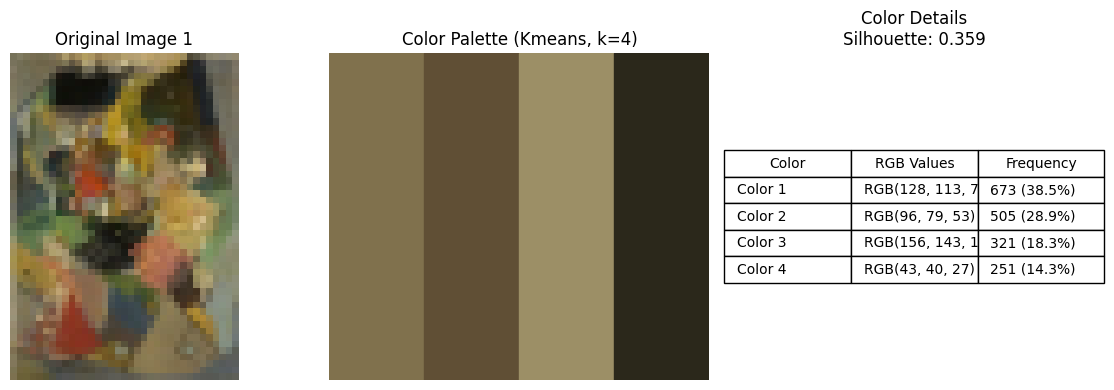

K-Means k=4 palette completed successfully


In [143]:
kmeans_palette_pipeline = Pipeline(
    steps=[("image_load", ImageUtilities(scale_percent=35)),
           ('color_palette',
            ColorPalette(method='kmeans', k=4, sort_by_frequency=True))])

print("=== K-Means Color Palette (k=4) ===")
kmeans_results = kmeans_palette_pipeline.fit_transform(imageNames)
print("K-Means k=4 palette completed successfully")

Scalating images to 35% of original size
=== K-Means PCA Visualization (k=4) ===
Loaded 1 images
Generating PCA plot for image 1 using kmeans with k=4


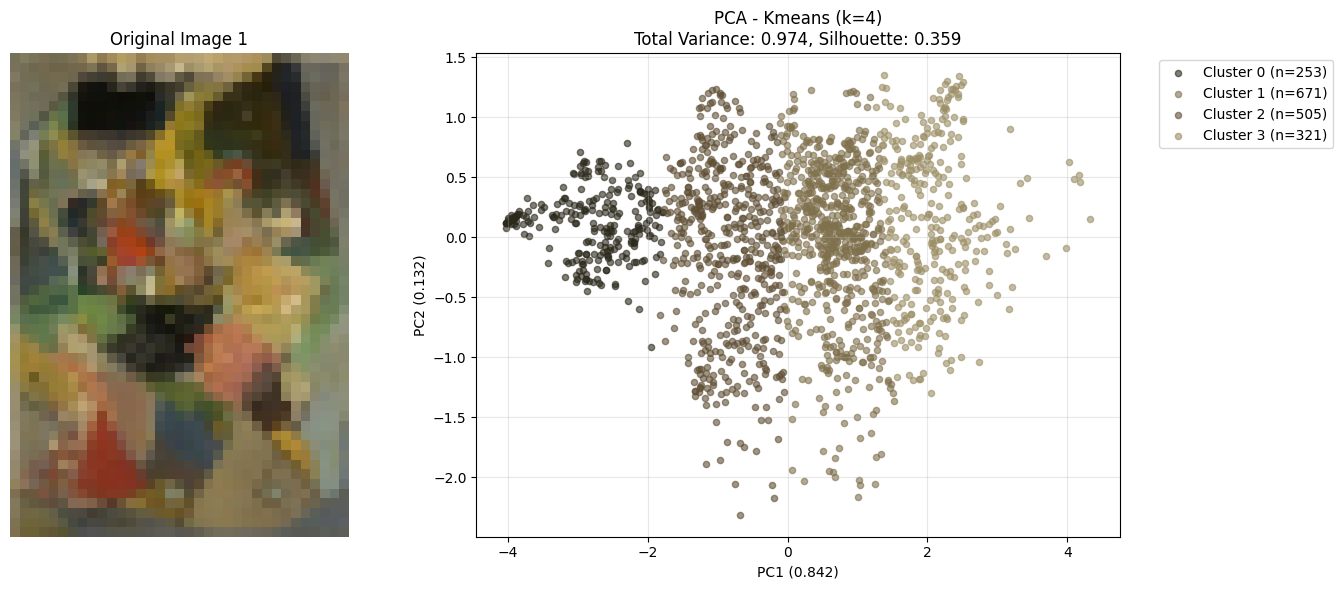

K-Means PCA k=4 completed successfully


In [144]:
kmeans_pca_pipeline = Pipeline(
    steps=[("image_load", ImageUtilities(scale_percent=35)
            ), ('pca_plot', PCAPlot(method='kmeans', k=4, n_components=2))])

print("=== K-Means PCA Visualization (k=4) ===")
kmeans_pca_results = kmeans_pca_pipeline.fit_transform(imageNames)
print("K-Means PCA k=4 completed successfully")


Scalating images to 35% of original size
Loaded 1 images
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1750 samples in 0.001s...
[t-SNE] Computed neighbors for 1750 samples in 0.029s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1750
[t-SNE] Computed conditional probabilities for sample 1750 / 1750
[t-SNE] Mean sigma: 0.182005


/Users/I864098/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.903862
[t-SNE] KL divergence after 1000 iterations: 0.578774


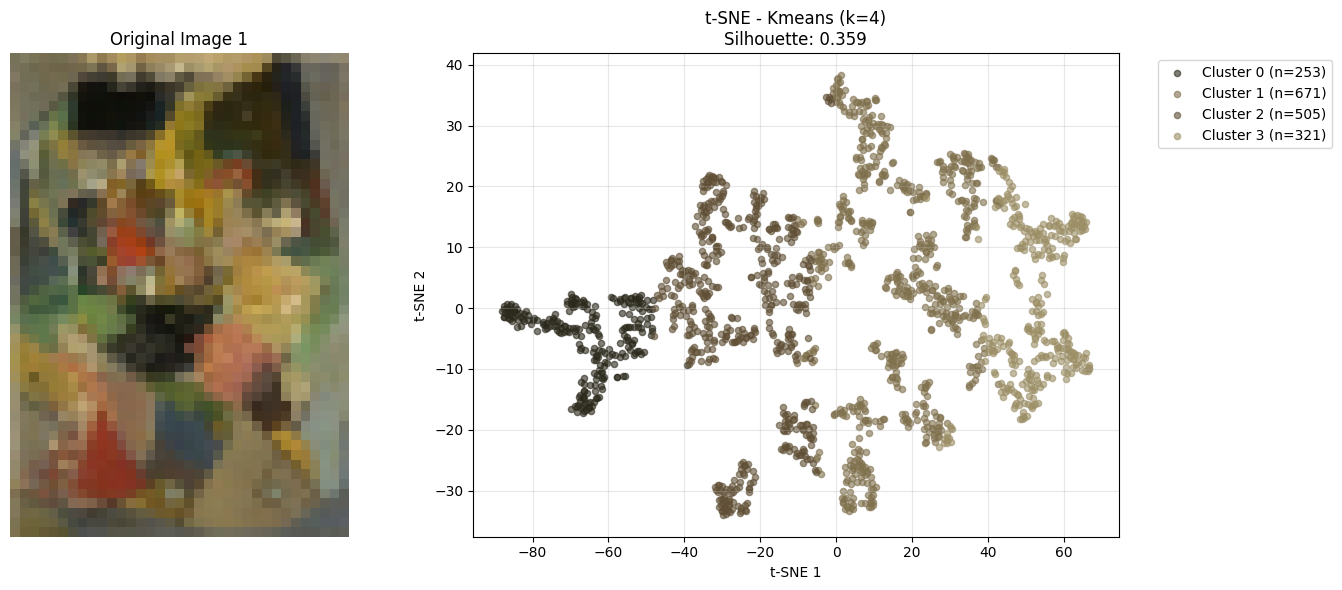

t-SNE completed:
  - Perplexity used: 30


In [145]:
kmeans_tsne_pipeline = Pipeline(
    steps=[("image_load", ImageUtilities(scale_percent=35)
            ), ('tsne_plot', TSNEPlot(method='kmeans', k=4, perplexity=30))])

kmedoids_tsne_results = kmeans_tsne_pipeline.fit_transform(imageNames)